# <center>Fuzzy Clustering</center>
## <center>Inclass Project 1 - MA4144</center>

This project contains 9 tasks/questions to be completed, some require written answers. Open markdow cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

Use this cell to use any include any imports

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score

**Q1.** In the following cell load the data (in the file SMDataRefined.csv) to a pandas dataframe, and display the data. Then get the data into a numpy matrix $X$, each row corresponding to a datapoint and each column to a feature, in our case whether a certain token exists ($1$) or not ($0$). Let us denote the number of rows of $X$ by $N$ and the number of columns by $M$.

**About the dataset**: Each row in the dataset refers to a social media post. The first column refers to the number of likes received by each post (standardized between to the interval $[0, 1]$), the columns after that will denote the presence of a certain word (token) in the text of the post. For example, a $1$ in the column "TextToken_life" denotes that the particular post contained the word "life" in it and $0$ otherwise. These will be the features of our dataset. Our aim is to cluster these social media posts based on number of likes and words contained in it.

In [223]:
#load data to a pandas dataframe
data = pd.read_csv('SMDataRefined.csv')
#display data
data.head()



,Likes,TextToken_life,TextToken_joy,TextToken_night,TextToken_heart,TextToken_laughter,TextToken_dreams,TextToken_feeling,TextToken_day,TextToken_like,TextToken_new
0,0.285714,0,0,0,0,0,0,0,1,0,0
1,0.000000,0,0,0,0,0,0,0,0,0,0
2,0.428571,0,0,0,0,0,0,0,0,0,0
3,0.071429,0,0,0,0,0,0,0,0,0,0
4,0.214286,0,0,0,0,0,0,0,0,0,1


In [225]:
#get data into a numpy array
X = data.values
print(type(data))
print(data.shape)


<class 'pandas.core.frame.DataFrame'>
(732, 11)


**Q2.** In the following cell create a new function named $\textrm{initMu}$, that takes in two parameters $\textrm{npoints}$ and $\textrm{nclusters}$ and outputs the membership matrix for $\textrm{npoints}$ number of data points and $\textrm{nclusters}$ number of clusters. Recall from the lecture that the membership matrix $U$ of dimension $N \times c$ has the following properties.

1. $0 \leq u_{ij} \leq 1$
2. $\sum\limits_{j = 1}^{c}u_{ij} = 1$ for all $i = 1,2, \cdots, N$

You can do a random initialization. Here $\textrm{npoints} = N$ and $\textrm{nclusters} = c$.

In [230]:
def initMu(npoints, nclusters):
    #TODO fill in the code
    #initaialize random matrix with size npoints x nclusters
    U = np.random.rand(npoints, nclusters)
    #normalize the matrix
    U = U / np.sum(U, axis=1, keepdims=True) 
    return U



**Q3.** In the following cell create a function named $\textrm{calculateCenters}$ that computes and returns centers $v_j$, $j = 1, 2, \cdots, c$ (as $c \times M$ matrix) given the data matrix $X$ and the membership matrix $U$. Recall the following update formula for $v_j$ from the lectures.

$v_j = \frac{\sum\limits_{i = 1}^N {\left( \frac{u_{ij}}{u_{max}} \right)}^{m_1} x_i}{\sum\limits_{i = 1}^N {\left( \frac{u_{ij}}{u_{max}} \right)}^{m_1}}$

Here $u_{max} = max \left(u_{1j}, u_{2j}, \cdots, u_{Nj} \right)$ and $m_1 \in [1, \infty)$ is a hyperparameter we discussed in class, and will be passed in as a parameter to the function.

The most efficient way to do this computation is by matrix multiplications. Try to find the appropriate matrix multiplication. You may need to transpose certain matrices.

In [231]:
def calculateCenters(X, U, m):
    #TODO fill in the code
    u_max = np.max(U, axis=0,keepdims=True)
    U_weighted = (U / u_max) ** m
    denominator = np.sum(U_weighted, axis=0,keepdims=True).T
    numerator =np.matmul((U_weighted).T, X) 
    centers = numerator / denominator
    return centers



**Q4.** In the following cell create a function named $\textrm{updateMu}$ that updates the membership matrix $U$ given the data matrix $X$ and the $\textrm{centers}$. Recall the following update formula for $u_{ij}$ from the lectures.

$u_{ij} = {\left[ \sum\limits_{l = 1}^c { \left( \frac{d_{ij}}{d_{il}} \right)}^{\frac{2}{m_2 - 1}} \right]}^{-1}$
where $d_{ij}$ is the distance between the $i$th data point and the $j$th cluster center. $m_2 \in (1, \infty)$ is another hyperparameter that is passed into the function.

To compute distances sklearn.metrics.pairwise.pairwise_distances could be useful. For these computations, try to avoid for loops as much as possible and use the tools offered by numpy for matrix manipulations for example such as numpy.tile.

The function should finally return the updated $U$ matrix.

In [304]:
def updateMu(X, centers, m):
    #TODO fill in the code
    distances = pairwise_distances(X, centers)  # Shape should be (npoints, nclusters)
    distances = np.maximum(distances, 1e-12) # Avoid division by zero
    
    #ratio term
    distances_ratio = distances[:, :, np.newaxis] / distances[:, np.newaxis, :]  # Shape should be (npoints, nclusters, nclusters)
    #update the membership matrix
    U_new = 1 / np.sum(np.power(distances_ratio, 2 / (m - 1)), axis=2)
    
    U_new = U_new / np.sum(U_new, axis=1, keepdims=True)
    
    return U_new


**Q5.** Use following cell to create a function called $\textrm{fuzzyClustering}$ that takes in a data matrix $X$ the number of clusters $\textrm{nclusters}$, $m_1$, $m_2$ hyperparameters and then returns a membership matrix $U$ and nclusters number of centers for each cluster as a matrix whose rows will correspond to the centers. Recall that the fuzzy clustering algorithm,

1. Initialize the membership matrix $U$
Repeat the following steps while max iterations (maxIter) reached or change in norm of $U$ is greater than a specified tolerance (tol).
2. Compute cluster centers
3. Update membership matrix

The function you create should be able to compute the norm between the $U$ matrices from consecutive iterations and plot a graph depicting the variation of the change in norm of $U$ against the number of iterations. 

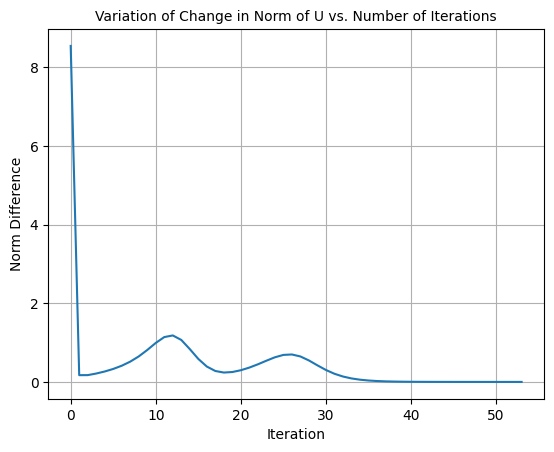

In [306]:
def fuzzyClustering(X, m1, m2, nclusters, maxiter = 5000, tol = 10**(-5)):
    #TODO fill in the code
    N, M = X.shape
    U = initMu(N, nclusters)
    norms = []
    
    for i in range(maxiter):
        centers = calculateCenters(X, U, m1)
        U_new = updateMu(X, centers, m2)
        norm_diff = np.linalg.norm(U - U_new)
        norms.append(norm_diff)
        
        # Check for convergence
        if norm_diff < tol:
            #print(f"Converged at iteration {i}")
            break
            
        U = U_new
    
  
    return U, centers, norms

#run the fuzzy clustering algorithm

def plot_norms(norm_diff):
    plt.plot(norm_diff)
    plt.xlabel('Iteration')
    plt.ylabel('Norm Difference')
    plt.title('Variation of Change in Norm of U vs. Number of Iterations', fontsize=10)
    plt.grid(True)
    plt.show()
    
U, centers ,norm_diff= fuzzyClustering(X, 1.5, 2,3 )
plot_norms(norm_diff)



**Q6.** Run the fuzzyClasssification algorithm with different hyperparameters $m_1, m_2, \textrm{nclusters}$, note the plot of $U$-norm difference against the number of iterations. <font color='blue'>What can you say about it?</font>

Now lets use the fuzzy membership to find some crisp cluster labelling $\textrm{yfuzzy}$ to for each data point. For a given datapoint you'll assign the cluster labelling by looking at which cluster assigns the largest membership value. numpy.argmax function would be useful in this case. Again avoid for loops. 

Testing with m1=2, m2=1.2, nclusters=2
data: (732, 11)
U shape: (732, 2)
Crisp Cluster Labels: [1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1
 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1
 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1
 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1
 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0
 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1
 1 0 

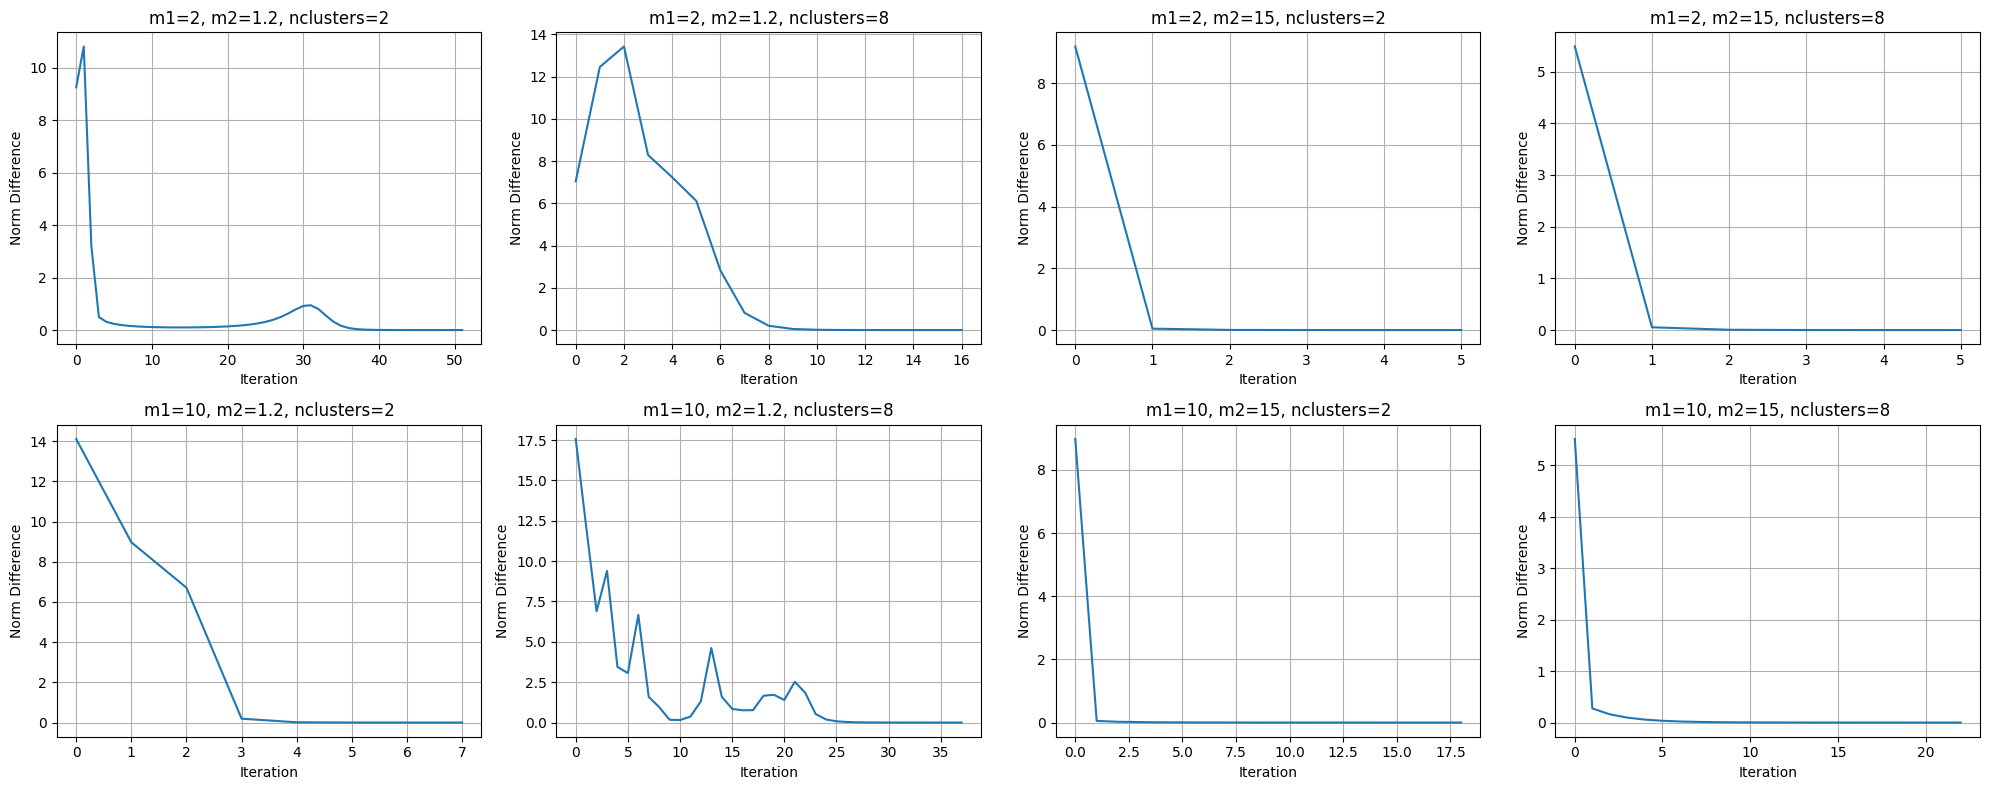

In [307]:
#TODO fill in the code
m1_set = [2, 10]
m2_set = [1.2, 15]
nclusters_values = [2, 8]
yfuzzy = []

def plot_norms(data, m1_set, m2_set, nclusters_values):
    total_combinations = len(m1_set) * len(m2_set) * len(nclusters_values)
    plots_per_row = 4
    num_rows = (total_combinations + plots_per_row - 1) // plots_per_row

    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(5 * plots_per_row, 4 * num_rows))
    axes = axes.flatten()

    plot_idx = 0

    for m1 in m1_set:
        for m2 in m2_set:
            for nclusters in nclusters_values:
                print(f"Testing with m1={m1}, m2={m2}, nclusters={nclusters}")

                # Run fuzzy clustering
                U, centers, norms = fuzzyClustering(X, m1=m1, m2=m2, nclusters=nclusters, maxiter=5000, tol=1e-5)
                print("data:", X.shape)
                print("U shape:", U.shape)
                # Plot norms
                ax = axes[plot_idx]
                ax.plot(norms)
                ax.set_title(f"m1={m1}, m2={m2}, nclusters={nclusters}")
                ax.set_xlabel('Iteration')
                ax.set_ylabel('Norm Difference')
                ax.grid(True)

                # Generate and print crisp labels
                yfuzzy = get_crisp_labels(U)
                
                print("Crisp Cluster Labels:", yfuzzy)
                print("="*50)

                plot_idx += 1

    # Remove any unused subplots
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

def get_crisp_labels(U):
    return np.argmax(U, axis=1)


# Example usage with synthetic data
from sklearn.datasets import make_blobs
data, _ = make_blobs(n_samples=300, centers=4, random_state=42)

plot_norms(X, m1_set, m2_set, nclusters_values)
   



<font color= 'green'> My Explanation:
#### Effects of Hyperparameters

- **Low Values for \( m_1 \) and \( m_2 \)**:
  - Lower values for \( m_1 \) and \( m_2 \)  lead to slower convergence in the clustering process. However, these lower values tend to produce more well-defined and distinct clusters, as the membership values are less influenced by neighboring clusters.

- **High Values for \( m_1 \) and \( m_2 \)**:
  - Higher values for \( m_1 \) and \( m_2 \) result in faster convergence of the clustering algorithm. Despite the quicker convergence, the clusters may be less distinct, as the higher values smooth out the membership values across clusters, potentially merging clusters that might otherwise be separate.

#### Impact of the Number of Clusters

- **Fewer Clusters**:
  - Choosing a smaller number of clusters speeds up convergence but may oversimplify the data, failing to capture its underlying complexity and missing important patterns.

- **More Clusters**:
  - Opting for a larger number of clusters captures more detailed information about the data, allowing for a more precise representation of its structure. This can slow down convergence, as the algorithm needs to work harder to define and separate the additional clusters, but it provides a more nuanced view of the data.
</font>

**Q7.** The Silhoutte score is a measure of how well the clustering has been done, the closer the score to $1.0$ the better the clustering. Refer to sklearn.metrics.silhouette_score. Determine the best choice of hyperparameters $m_1, m_2, \textrm{nclusters}$ through a grid search based on the silhoutte score as the evaluation metric. <font color='blue'>Report the best combination of hyperparameters.</font> For the grid search try $m_1 = 1.0, 1.2, \cdots, 3.0$, $m_2 = 1.2, 1.4, \cdots, 3.0$, $\textrm{nclusters} = 2, 3, \cdots, 15$.


Highest Silhouette Score: 0.585513631689677
Optimal Hyperparameters: m1=1.0, m2=1.2, num_clusters=15


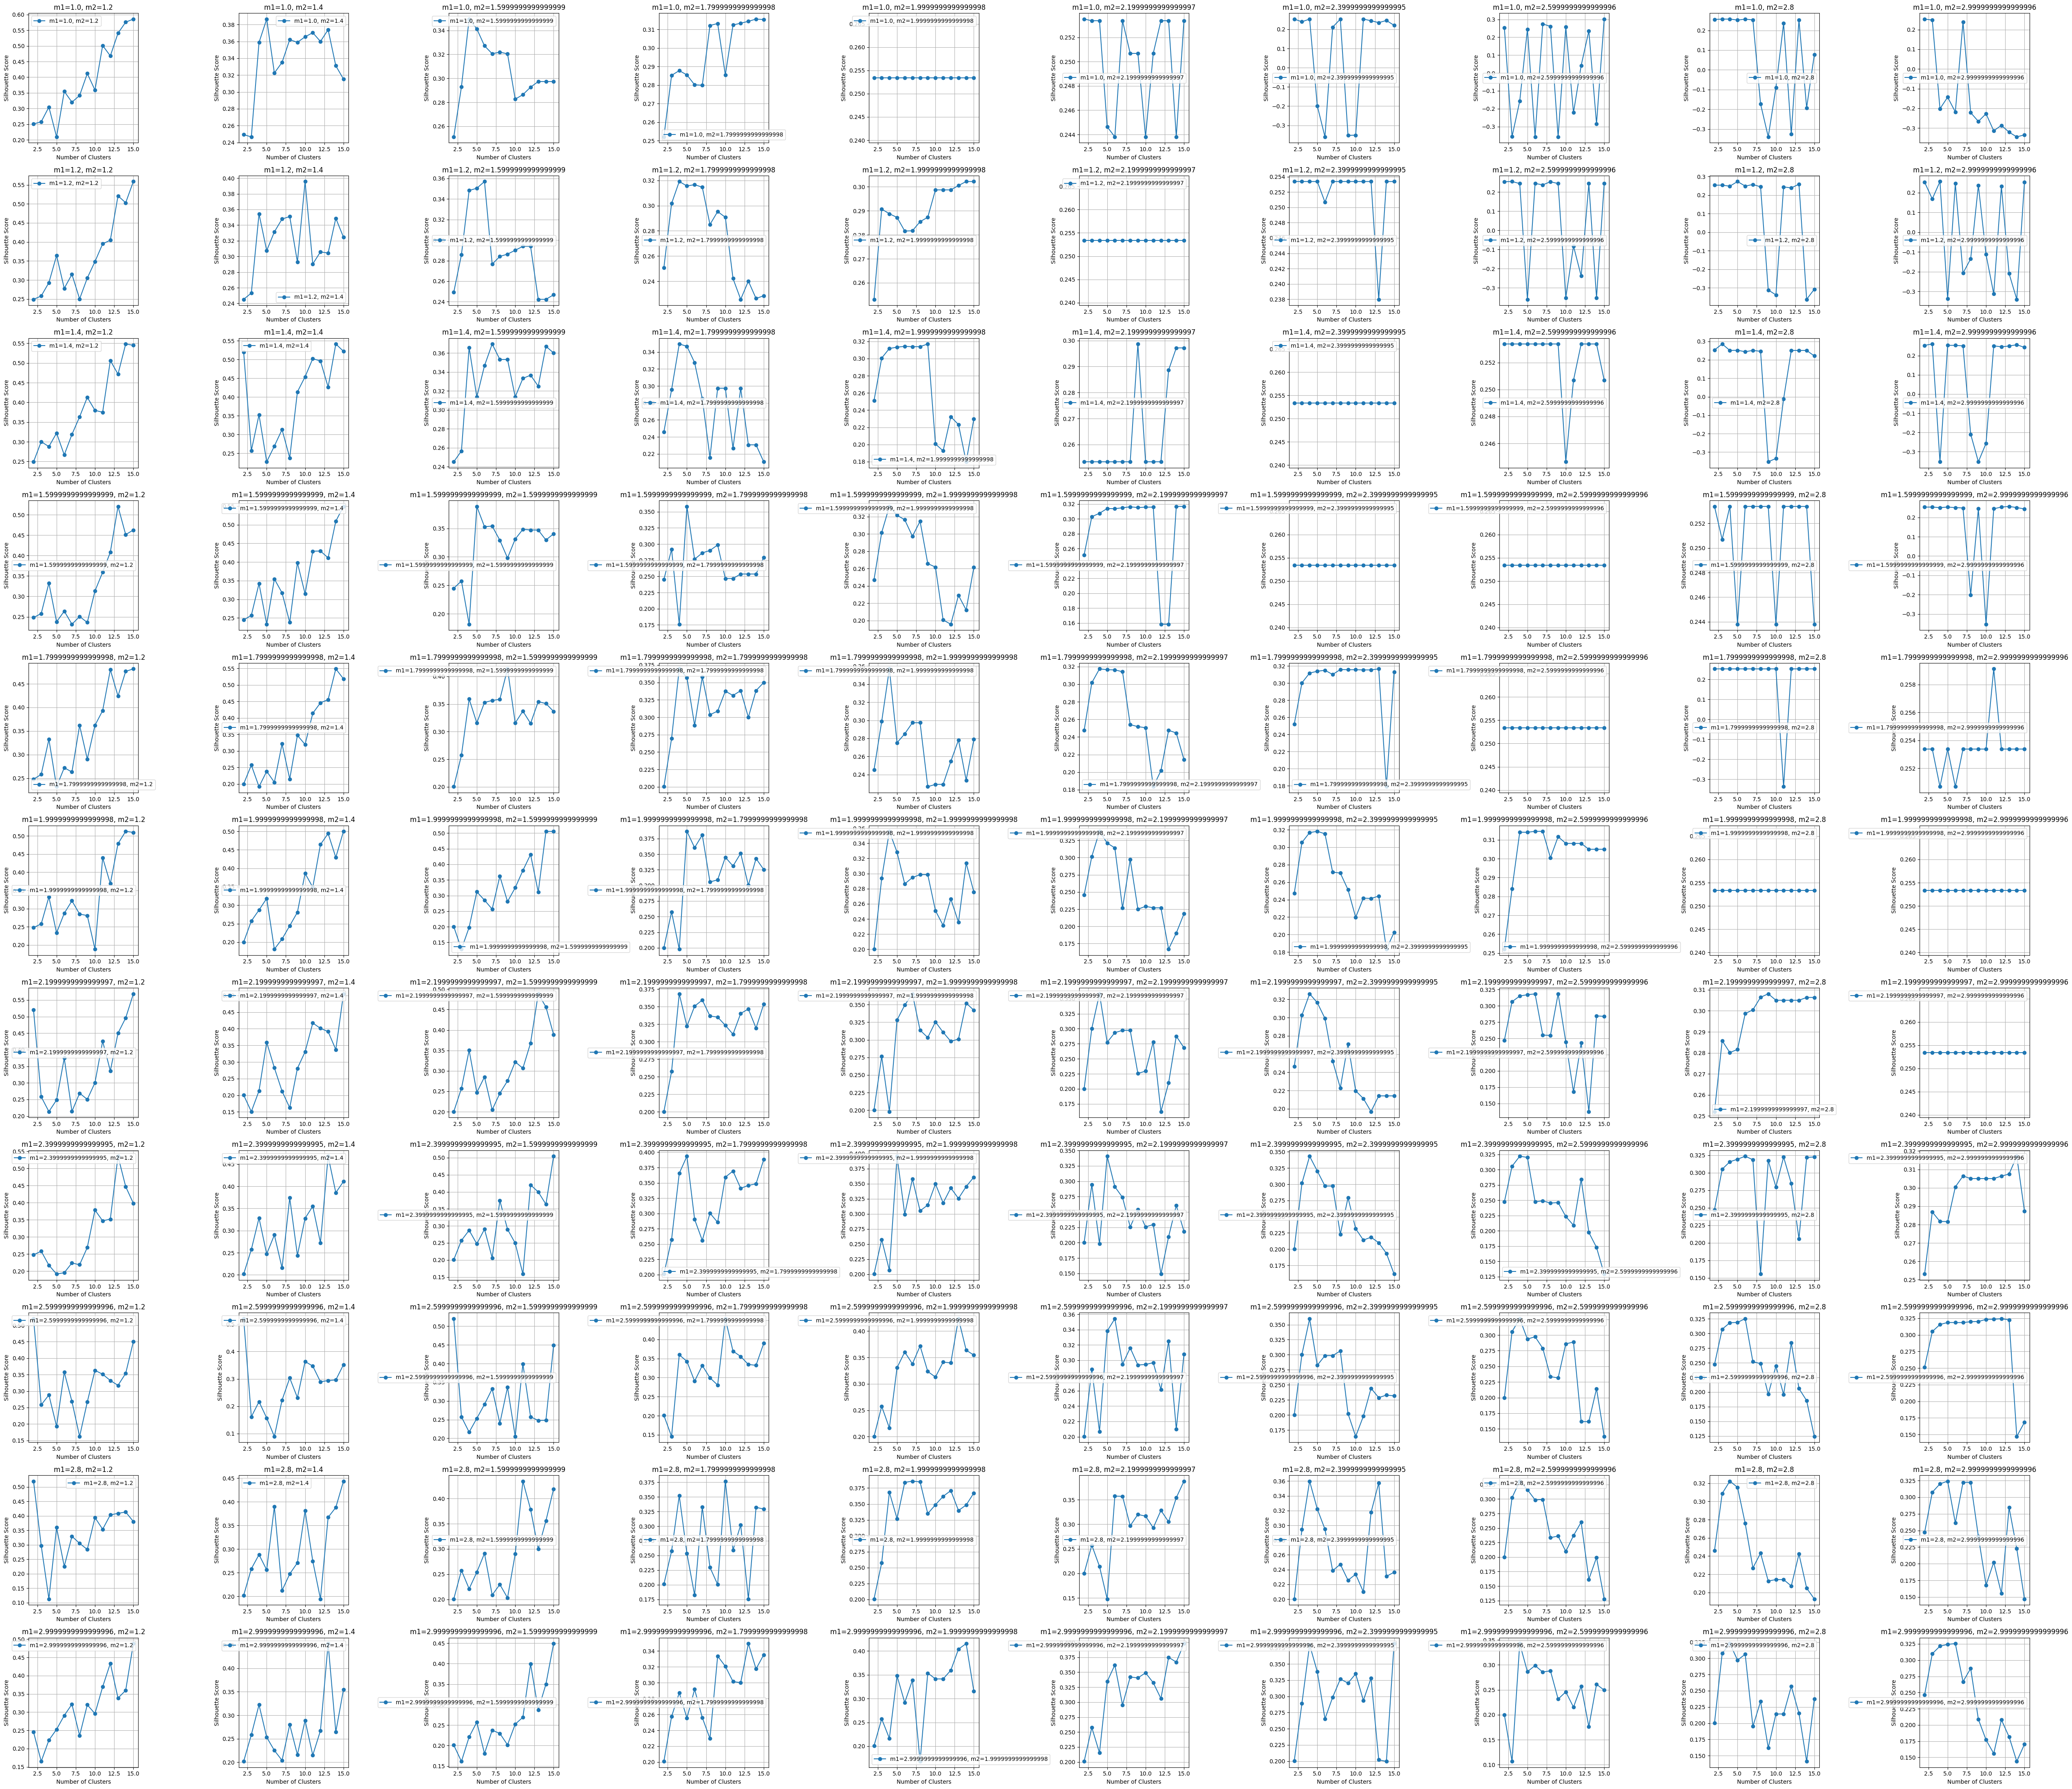

In [308]:
#TODO fill in the code

# Define the range of hyperparameters
m1_range = np.arange(1.0, 3.2, 0.2)
m2_range = np.arange(1.2, 3.2, 0.2)

num_clusters_range = list(range(2, 16))

# Initialize best score and parameters
max_score = -1
optimal_params = None

# Collect results for plotting
results_data = []

# Evaluate all combinations of m1, m2, and num_clusters
for num_clusters in num_clusters_range:
    for param_m1 in m1_range:
        for param_m2 in m2_range:
            #print(f"Evaluating with m1={param_m1}, m2={param_m2}, num_clusters={num_clusters}")
            
            # Perform fuzzy clustering
            membership_matrix, cluster_centers, norm_diffs = fuzzyClustering(X, m1=param_m1, m2=param_m2, nclusters=num_clusters, maxiter=500, tol=1e-5)
            
            # Determine cluster assignments
            cluster_assignments = np.argmax(membership_matrix, axis=1)
            
            # Calculate the silhouette score
            silhouette = silhouette_score(X, cluster_assignments)
            #print(f"Silhouette Score: {silhouette}")
            
            # Record the results
            results_data.append((param_m1, param_m2, num_clusters, silhouette))
            
            # Update best score and parameters if needed
            if silhouette > max_score:
                max_score = silhouette
                yfuzzy = cluster_assignments
                optimal_params = (param_m1, param_m2, num_clusters)

print(f"\nHighest Silhouette Score: {max_score}")
print(f"Optimal Hyperparameters: m1={optimal_params[0]}, m2={optimal_params[1]}, num_clusters={optimal_params[2]}")

# Optional: Plot results to visualize
results_data = np.array(results_data)

# Determine the number of plots required
total_plots = len(m1_range) * len(m2_range)
plots_per_row = 10
num_rows = (total_plots + plots_per_row - 1) // plots_per_row  # Calculate rows needed

# Set up the figure for plotting
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(5 * plots_per_row, 4 * num_rows))
axes = axes.flatten()  # Flatten the array of axes for easier indexing

current_plot_index = 0

for param_m1 in m1_range:
    for param_m2 in m2_range:
        ax = axes[current_plot_index]
        subset_data = results_data[(results_data[:, 0] == param_m1) & (results_data[:, 1] == param_m2)]
        ax.plot(subset_data[:, 2], subset_data[:, 3], label=f'm1={param_m1}, m2={param_m2}', marker='o')
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Silhouette Score')
        ax.set_title(f'm1={param_m1}, m2={param_m2}')
        ax.legend()
        ax.grid(True)
        current_plot_index += 1

# Remove any unused subplots
for i in range(current_plot_index, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to fit all plots
plt.tight_layout()
plt.show()

**Q8.** For the best combination of hyperparameters run the following visualization function with different values for $0 \leq f_1 < f_2 < \textrm{nclusters}$. <font color='blue'>What do you see? Explain the purpose of the code and what you would expect through this?</font>

<font color="green">

Best combination of hyper parameters are

    no of clusters = 15
    m1 = 1.0
    m2 = 1.2

    
</font>

In [309]:
def visualizeClusters2D(X, yfuzzy, f1, f2):
    colorlist = ['black', 'gray', 'red', 'sienna', 'green', 'blue', 'gold', 'darkorange', 'olive', 'lavendar', 'salmon', 'teal', 'pink', 'magenta', 'tan', 'wheat']

    for i in range(8):
        plt.scatter(X[yfuzzy == i, f1], X[yfuzzy == i, f2], color = colorlist[i])

    plt.show()


optimal_params: (1.0, 1.2, 15)


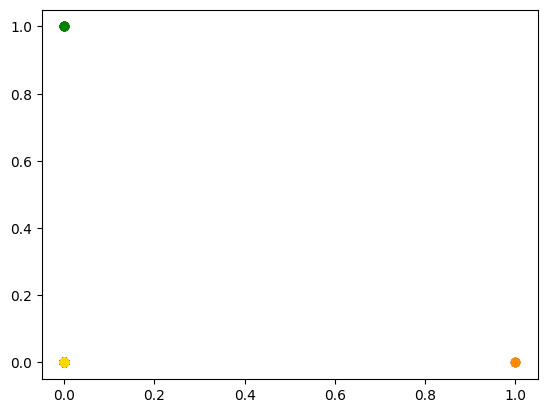

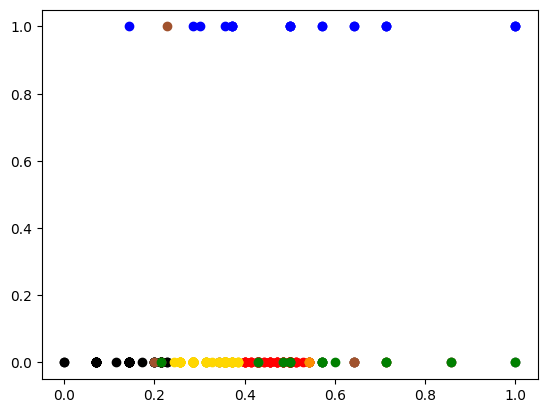

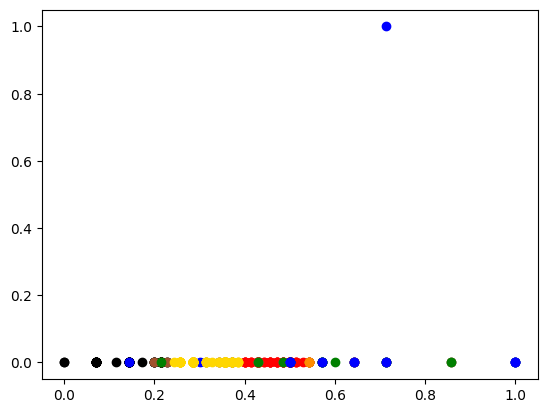

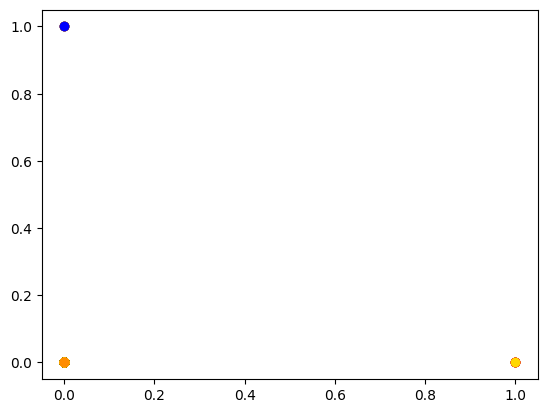

In [315]:
#TODO fill in the code
# Extract the optimal hyperparameters
print("optimal_params:", optimal_params)
best_m1 = optimal_params[0]
best_m2 = optimal_params[1]
best_num_clusters = optimal_params[2]

# Perform fuzzy clustering with the best hyperparameters
U_optimal, centers_optimal, norm_optimal = fuzzyClustering(X, m1=best_m1, m2=best_m2, nclusters=best_num_clusters, maxiter=500, tol=1e-5)

# Determine the final cluster labels
final_labels = np.argmax(U_optimal, axis=1)

# Visualize the clustering results using various feature pairs
visualizeClusters2D(X, final_labels, f1=1, f2=2)  
visualizeClusters2D(X, final_labels, f1=0, f2=3)
visualizeClusters2D(X, final_labels, f1=0, f2=10)
visualizeClusters2D(X, final_labels, f1=7, f2=9)


My Explanation:
Depending on the features we choose, some visualizations may show overlapping clusters, while others may not. This is due to the differences in the selected feature pairs. The goal of this code is to display the clusters in a 2D space. By examining different feature pairs, we can observe how well the clusters are separated and how they appear in various 2D spaces.


**Q9.** Load (to a pandas dataframe) the actual dataset (SMData.csv) from which the previous dataset was cleaned out. Match each entry in this dataset with the labels you found out through clustering using the best combination of hyperparameters. Go through a few of those clustered entries and notice any patterns (or common sentiment) in the text (the "Text" column of this dataset) of each entry within clusters vs outside the clusters. The label of the $i$th entry in the dataset $= \textrm{yfuzzy}[i]$. <font color='blue'>Explain any observations. Based on your observations, is the clustering successful?</font>

In [316]:
#TODO fill in the code
df_initial = pd.read_csv('SMData.csv')


df_initial['Cluster_Label'] = yfuzzy

df_initial[df_initial['Cluster_Label'] == 0].head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Cluster_Label
240,241,245,Leafing through the pages of an old photo alb...,Nostalgia,2017-05-18 14:45:00,TaleWeaver,Twitter,#Nostalgia #PhotoAlbumStories,12.0,25.0,USA,2017,5,18,14,0
254,255,259,"Playfully dancing in the rain of laughter, a ...",Playful,2020-07-08 18:00:00,RainDancer,Facebook,#Playful #DanceInTheRain,22.0,44.0,Canada,2020,7,8,18,0
263,264,268,"With a zestful heart, sprinting through field...",Zest,2023-03-30 16:30:00,MeadowSprinter,Instagram,#Zest #FieldsOfEnthusiasm,16.0,32.0,India,2023,3,30,16,0
275,276,280,"Playfully juggling responsibilities, a circus...",Playful,2019-11-18 15:15:00,JugglingArtist,Instagram,#Playful #JugglingResponsibilities,25.0,50.0,USA,2019,11,18,15,0
289,290,294,"Playfully juggling responsibilities, a circus...",Playful,2019-11-18 15:15:00,JugglingArtist,Instagram,#Playful #JugglingResponsibilities,25.0,50.0,USA,2019,11,18,15,0


In [317]:
# Display a few entries from each cluster
for cluster in set(yfuzzy):
    print(f"\nCluster {cluster} entries:")
    print(df_initial[df_initial['Cluster_Label'] == cluster].head(5))  # Display the first 5 entries for each cluster

# Example: Display a few entries not belonging to the clusters (optional)
print("\nEntries not in clusters:")
print(df_initial[df_initial['Cluster_Label'] == -1].head(5))  # Assuming -1 for non-clustered entries if applicable


Cluster 0 entries:
     Unnamed: 0.1  Unnamed: 0  \
240           241         245   
254           255         259   
263           264         268   
275           276         280   
289           290         294   

                                                  Text          Sentiment  \
240   Leafing through the pages of an old photo alb...   Nostalgia          
254   Playfully dancing in the rain of laughter, a ...           Playful    
263   With a zestful heart, sprinting through field...              Zest    
275   Playfully juggling responsibilities, a circus...           Playful    
289   Playfully juggling responsibilities, a circus...           Playful    

               Timestamp                 User     Platform  \
240  2017-05-18 14:45:00   TaleWeaver            Twitter     
254  2020-07-08 18:00:00          RainDancer     Facebook    
263  2023-03-30 16:30:00      MeadowSprinter    Instagram    
275  2019-11-18 15:15:00      JugglingArtist    Instagram    
289  201

In [318]:
# Counting the number of entries in each cluster
cluster_counts = df_initial['Cluster_Label'].value_counts()

# Printing the result
print(cluster_counts)

Cluster_Label
7     214
2     204
12    114
5      37
14     23
11     22
9      18
1      18
4      17
8      16
0      16
13     16
3      10
6       4
10      3
Name: count, dtype: int64


In [319]:
# Sorting the clusters by their labels
sorted_clusters = sorted(cluster_counts.index)

# Iterate through each cluster and print the sentiment analysis
for cluster in sorted_clusters:
    print(f'Cluster No. : {cluster}')
    cluster_df = df_initial[df_initial['Cluster_Label'] == cluster]
    print(cluster_df['Sentiment'].value_counts())
    print('-' * 50)

Cluster No. : 0
Sentiment
 Playful             3
 Gratitude           2
 Joy                 2
 Happy               2
 Nostalgia           1
 Zest                1
 Contentment         1
 FestiveJoy          1
 Isolation           1
 Happiness           1
 Contentment         1
Name: count, dtype: int64
--------------------------------------------------
Cluster No. : 1
Sentiment
 Hopeful             3
 Desolation          3
 Inspired            2
 Free-spirited       2
 Melancholy          1
 Determination       1
 Serenity            1
 Devastated          1
 Ruins               1
 Resilience          1
 Enthusiasm          1
 Reflection          1
Name: count, dtype: int64
--------------------------------------------------
Cluster No. : 2
Sentiment
 Joy               22
 Happy             10
 Positive           9
 Excitement         8
 Neutral            6
                   ..
 Desperation        1
 Desolation         1
 Regret             1
 Loneliness         1
 Enchantment       

<font color='green'> My Explanation:


We observe that there are 15 clusters, indicating successful clustering since the clusters are distinct and contain similar content. But there are some considerable impairements in few clusters, indicating need for refinements.
ex:
- Some clusters, like Cluster 6, contain a few sentiments, which may suggest that the cluster is too broad.
- Other clusters, like Cluster 14, contain only a few sentiments, which could mean that these clusters are more narrowly defined.</font>


